# Affine transforms

clesperanto comes with an `affine_transform()` operation that can be used directly or as a set of smaller specialised operation like `rotation()`, `translation()`, `scale()`, etc.

This notebook demonstrates how to apply such transform on a 3D image.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage.io import imshow, imread

import pyclesperanto as cle

cle.select_device(1,"gpu")

(OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.274.02
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24217 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         6054 MB
	Max Clock Frequency:         2625 MHz
	Image Support:               Yes

(120, 160, 160)


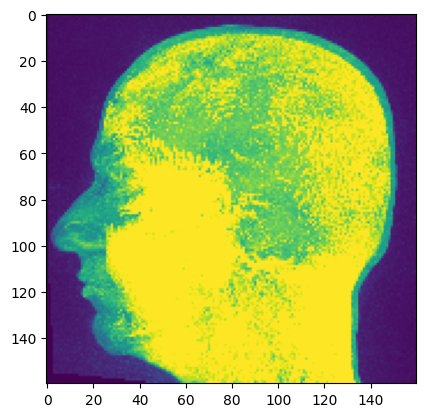

In [2]:
# Laod example data
input_image = imread("../data/Haase_MRT_tfl3d1.tif")
print(input_image.shape)
plt.imshow(input_image.max(axis=0))

## Rotation

For rotating an image, you need to provide angles corresponding to axes and defined if you want a centered or uncentered rotation.
- uncentered rotation have the axis of rotation at the origin coordinate of the image
- centered rotation have the axis of rotation at the centered coordinate of the image

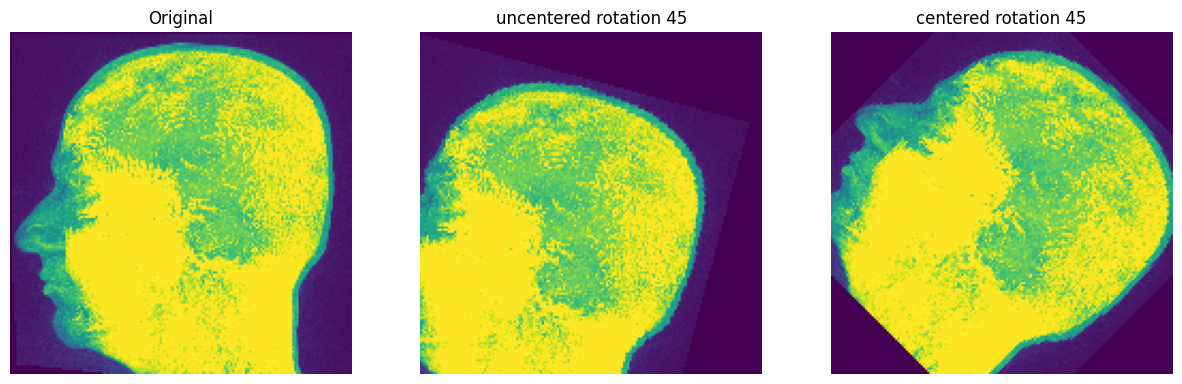

In [3]:
rotated_45 = cle.rotate(input_image, angle_z=45)
rotated_ofcenter = cle.rotate(input_image, angle_z=15, centered=False)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(input_image.max(axis=0))
ax[0].set_title("Original")
ax[1].imshow(rotated_ofcenter.get().max(0))
ax[1].set_title("uncentered rotation 45")
ax[2].imshow(rotated_45.get().max(0))
ax[2].set_title("centered rotation 45")
for a in ax:
    a.axis('off')
plt.show()

## Translation
Images can be translate by providing translation distances along axes:

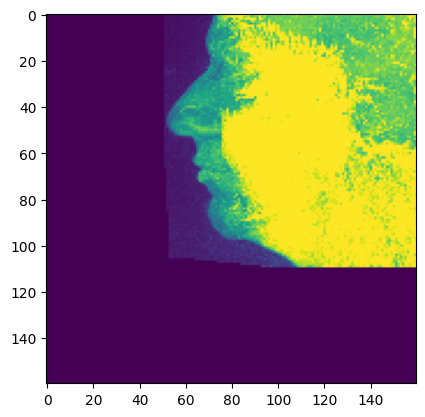

In [4]:
translated = cle.translate(input_image, translate_x=50, translate_y=-50)
plt.imshow(cle.pull(translated).max(axis=0))

## Rigid transform

Rigid transforms is a transformation combining all the previously seen operation: translations and rotations, into one operation. It is call `rigid` as it does not deform the image.

> See [Rigid Transformation](https://en.wikipedia.org/wiki/Rigid_transformation) in wikipedia

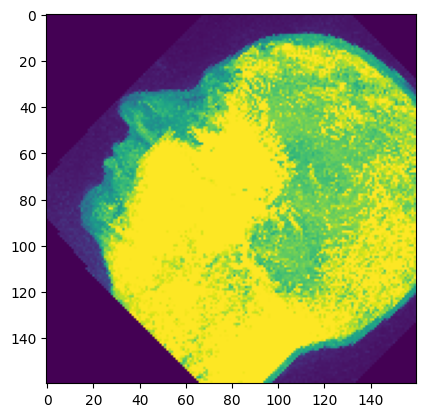

In [5]:
rigid_transformed = cle.rigid_transform(input_image, translate_x=20, angle_z=45)
plt.imshow(cle.pull(rigid_transformed).max(axis=0))

## Scaling and `resize`

You can scale the image by providing scaling factors. As it can deforme strongly the image, it is also a good function to show the `resize` parameter which allows to automatically compute the best output dimension to hold the transformed image.

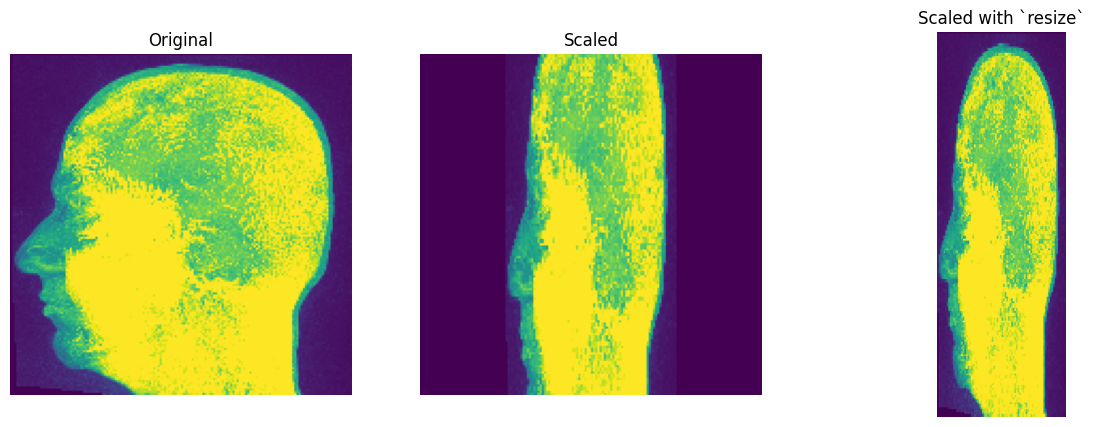

In [6]:
scaled = cle.scale(input_image, factor_x=0.5, factor_y=1.5)
scaled_resized = cle.scale(input_image, factor_x=0.5, factor_y=1.5, resize=True)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(input_image.max(axis=0))
ax[0].set_title("Original")
ax[1].imshow(scaled.get().max(0))
ax[1].set_title("Scaled")
ax[2].imshow(scaled_resized.get().max(0))
ax[2].set_title("Scaled with `resize`")
for a in ax:
    a.axis('off')
plt.show()

## Affine transforms

The affine transform is similar to the rigid transform but also include scaling and shearing. However, as the operation is more complicated, it requires a transformation matrix as an input.
Transformation matrix are (nD+1)x(nD+1), so 3x3 for a 2D image and 4x4 for a 3D image. 

> See [Affine Transformation](https://en.wikipedia.org/wiki/Affine_transformation) and [Transformation matrix](https://en.wikipedia.org/wiki/Transformation_matrix) in wikipedia

To setup an affine transform, we need first a transform matrix and pass it to the `affine_transform` function:

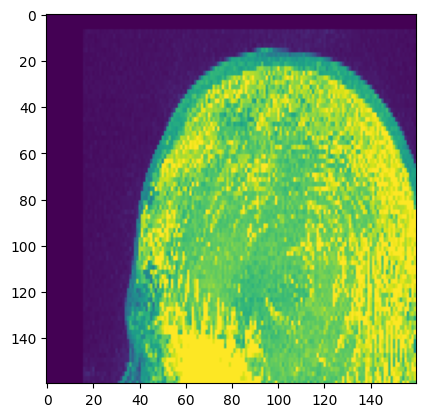

In [7]:
transform_matrix = np.asarray([
    [1, 0, 0, 15],
    [0, 2, 0, 5],
    [0, 0, 0.5, 0],
    [0, 0, 0, 1]
])
transformed_image = cle.affine_transform(input_image, transform_matrix=transform_matrix)
plt.imshow(cle.pull(transformed_image).max(axis=0))

Same as for the previous transform operation, we can use the `resize` parameter to use the correct output size.

# Interoperability with scikit-image
Scikit-image only supports 2D transforms and thus, we pick a slice to transform it.

We can use the `transforms` package of scikit-image to define an affine transform and apply it to the image.

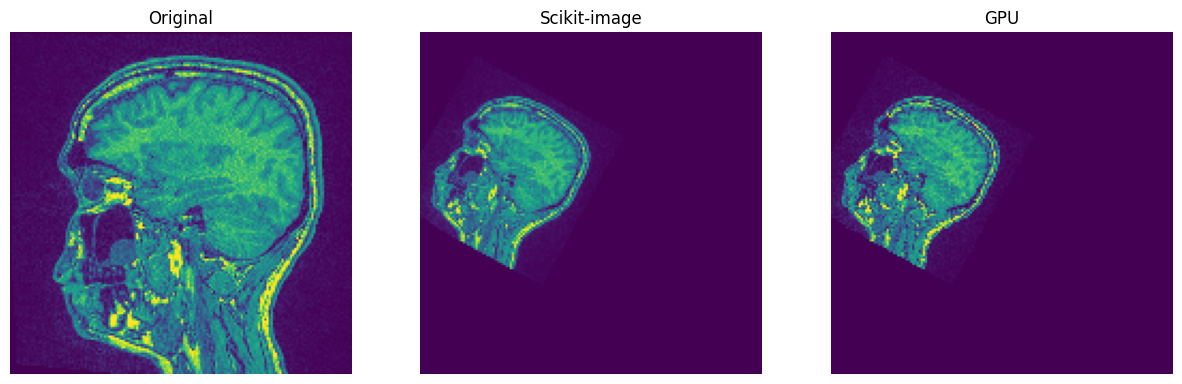

In [9]:
from skimage import transform as tf

transform = tf.AffineTransform(scale=0.5, translation=[25,10], rotation=0.5)

image = cle.pull(input_image)[80]
transformed_image = tf.warp(image, transform.inverse)
gpu_transformed_image = cle.affine_transform(image, transform_matrix=transform.params)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Original")
ax[1].imshow(transformed_image)
ax[1].set_title("Scikit-image")
ax[2].imshow(cle.push(gpu_transformed_image))
ax[2].set_title("GPU")
for a in ax:
    a.axis('off')
plt.show()

# Linear interpolation versus nearest neighbor interpolation

pyclesperanto transformation operation comes with two different interpolation option:
- nearest neighbor interpolation, which is the default one
- linear interpolation, which rely on hardware acceleration (not available on all devices)

> The linear interpolation adapts itself on the dimensionality of the input, if 2D it is a bilinear interpolation, a trilienear for a 3D input.

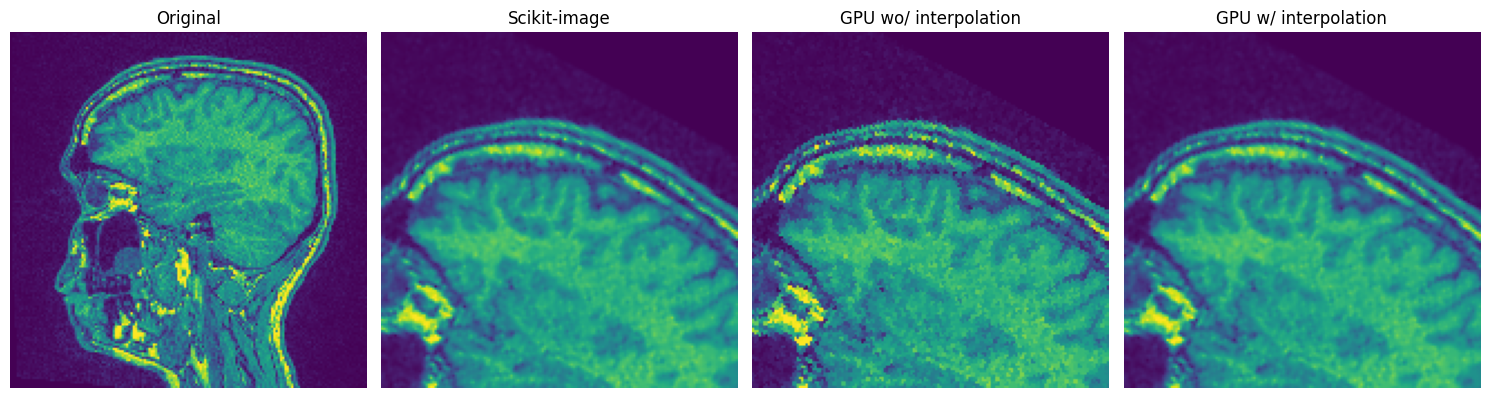

In [22]:
transform = tf.AffineTransform(scale=1.75, translation=[5,-30], rotation=0.5)

image = cle.pull(input_image)[80]
transformed_image = tf.warp(image, transform.inverse)
gpu_transformed_image = cle.affine_transform(image, transform_matrix=transform.params, interpolate=True)
gpu_transformed_image_nn = cle.affine_transform(image, transform_matrix=transform.params, interpolate=False)

fig, ax = plt.subplots(1, 4, figsize=(15, 10))
ax[0].imshow(image)
ax[0].set_title("Original")
ax[1].imshow(transformed_image)
ax[1].set_title("Scikit-image")
ax[2].imshow(gpu_transformed_image_nn)
ax[2].set_title("GPU wo/ interpolation")
ax[3].imshow(gpu_transformed_image)
ax[3].set_title("GPU w/ interpolation")
for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()